## Como os deputados votam: Exploração e tratamento dos dados
### Um projeto de aprendizado não supervisado


Mas, quando passamos a falar e politica na prática, considerando os projetos de lei, votações na câmara e decretos governamentais ninguém entende muito bem. Se tratando de um país do tamanho do Brasil é entendível que as regras de governo sejam complexas, cheias de processos e burocracias. É parte do sistema democrático.

Uma parte importante desse processo são as votações na câmara dos deputados. É la que são aprovados projetos, leis ementas e outras coisas do direito que mudam diretamente ou indiretamente nossa vida enquanto cidadãos. O interessante é que câmara legislativa disponibiliza um volume imenso de dados sobre o que acontece nessas votações, nos permitindo e incentivando a explorar esses dados.

Sabendo que a política é atualmente um assunto muito importante para nós brasileiros, mas que não entendemos muito bem o comportamento dos parlamentares nas votações e existem dados que nos permitem explorar um pouco esse comportamento, surgiu a ideia de desenvolver esse projeto: um estudo sobre os dados das votações na câmara dos deputados.

Essa é a segunda parte de três. Aqui eu irei explorar os dados extraidos na primeira parte (LIIINNNNKKK___1)  e explicar um pouco os critérios que eu usei para filtrar os dados obtidos.


In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from requests import get
import itertools

from tqdm.notebook import tqdm, trange
import time 

### O quanto as inidcações do partido afetam no voto dos deputados?

A primeira coisa que eu queria explorar era a relação entre o voto dos deputados e o voto indicado pelos partidos. O que temos para analisar isso são como cada deputado votou em 1200 votações da câmara e o que cada partido orientou aos seus deputados em 1200 votações. Esse dois conjuntos de votações não necessariamente são iguais, de modo que algumas votações só existem no ocnjunto dos deputados e algumas só no conjunto dos partidos. O primeiro passo é importar os datasets com que iremos trabalhar:

In [20]:
votos = pd.read_csv(r'data\votos.csv')
orientacoes = pd.read_csv(r'data/orientacoes.csv')
deputados = pd.read_csv(r'data/deputados.csv')
df_indexed = deputados.merge(votos, left_on='id',
                             right_on='cod_deputado')

df_indexed= df_indexed.set_index('id')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,47,67,69,113,166,182,190,206,229,230,248,258,626,640,644,742,753,754,763,783,805,834,835,909,981,987,1001,1002,1019,1045,1047,1056,1079,1117,1140,1152,1155,1171,1184,1185) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


O dataset da câmara dos deputados disponibiliza as orientações dos partidos dividindo-as entre orientações do partido e orientações do bloco. Como minha intensão era de usar esse dado dos partidos como indice do dataset, eu combinei o tipo da orientação (se era de partido ou se era de um bloco) como o nome do partido. Então, para ler esse dataset primeiro precisamos re-dividir o tipo do nome dessas instituições por meio do código a seguir:

In [21]:
def read_cod_partido(cod_partido):
    if cod_partido[0]=='P':
        return ('P', cod_partido[1:])
    if cod_partido[0]=='B':
        return ('B',cod_partido[1:])
    if cod_partido[0]=='N':
        if cod_partido[4:] == 'Governo':
            return ('B',cod_partido[4:])
        else:
            return ('P',cod_partido[4:])

Part_cod=[read_cod_partido(a) for a in orientacoes.cod_partido]
orientacoes['partido']=[a[1] for a in Part_cod]
orientacoes['tipo']=[a[0] for a in Part_cod]

Divido o tipo do nome agora é preciso explorar os partidos que existem no dataset dos deputados e os partidos que existem no dataset das orientações. Primeiro coloquemos os dois como maiúsculas, depois é so comparar os dois sets.

In [22]:
partidos_deputados=set((deputados.siglaPartido.str.upper().unique()))

partidos_orientacoes= set(orientacoes[orientacoes.tipo=='P'].partido.str.upper())


print('partidos do dataset deputados :', partidos_deputados,'\n')
print('partidos do dataset orinetações :', partidos_orientacoes,'\n')
print('partidos que existem só no dataset das orientações: ',partidos_orientacoes-partidos_deputados,'\n')
print('partidos que existem só no dataset dos deputados: ',partidos_deputados-partidos_orientacoes,'\n')

partidos do dataset deputados : {'MDB', 'PCDOB', 'PV', 'PSDB', 'PSC', 'PP', 'REDE', 'PT', 'PSB', 'PTB', 'PSOL', 'PROS', 'AVANTE', 'NOVO', 'REPUBLICANOS', 'PDT', 'PSL', 'PATRIOTA', 'CIDADANIA', 'PODE', 'PSD', 'SOLIDARIEDADE', 'DEM', 'PL'} 

partidos do dataset orinetações : {'PCDOB', 'PV', 'MDB', 'PSDB', 'PSC', 'PRB', 'PMN', 'PP', 'REDE', 'PT', 'PPL', 'PSB', 'PR', 'PTB', 'PSOL', 'PROS', 'PPS', 'AVANTE', 'NOVO', 'PRP', 'REPUBLICANOS', 'PDT', 'PATRIOTA', 'PSL', 'PATRI', 'CIDADANIA', 'PODEMOS', 'REPUBLICAN', 'PODE', 'PHS', 'PSD', 'SOLIDARIEDADE', 'SOLIDARIED', 'DEM', 'PL'} 

partidos que existem só no dataset das orientações:  {'REPUBLICAN', 'PPS', 'PHS', 'PRP', 'PPL', 'SOLIDARIED', 'PATRI', 'PR', 'PRB', 'PMN', 'PODEMOS'} 

partidos que existem só no dataset dos deputados:  set() 



Aqui vemos que alguns partidos no dataset das orientações estão com nome errado ('PATRI', 'SOLIDARIED') e outros que não existem mais e foram aglutinados por outros partidos (como o PPL que virou parte do PCDOB). Para contornar isso eu decidi mudar essas categorias com alguma equivalencia usando um mapa/dicionario, como mostra o código a seguir:

In [23]:
map_partidos={'PATRI':'PATRIOTA',
             'REPUBLICAN':'REPUBLICANOS',
             'SOLIDARIED':'SOLIDARIEDADE',
             'PRP': 'PATRIOTA',
             'PRB':'REPUBLICANOS',
             'PPL': 'PCDOB',
             'PPS': 'CIDADANIA',
             'GOV.': 'GOVERNO'}

orientacoes['partido']=orientacoes.partido.str.upper().astype('category')

recats = {}
for cat in orientacoes['partido']:
    if cat in map_partidos:
        recats[cat] = map_partidos[cat]
    else:
        recats[cat] = cat
        
orientacoes['partido']=orientacoes.partido.apply(lambda x: recats[x])
orientacoes.partido.unique()

array(['PT', 'PSLPPPSD...', 'GOVERNO', 'NOVO', 'PSOL', 'CIDADANIA', 'PSB',
       'PDTSDPODE...', 'PATRIOTA', 'MINORIA', 'OPOSIÇÃO', 'PROS', 'REDE',
       'PR', 'PSL', 'PPMDBPTB', 'DEM', 'SOLIDARIEDADE', 'PCDOB', 'PV',
       'PSC', 'PODEMOS', 'PSDB', 'PSD', 'MAIORIA', 'REPUBLICANOS',
       'PDTAVANTE', 'PP', 'PTB', 'AVANTE', 'MDB', 'PODE', 'PDT',
       'PDTPROS...', 'PPPRPSD', 'PHS', 'PDTPODEPROS...', 'PL', 'PMN'],
      dtype=object)

Feito isso hora de medir o quanto cada deputado concorda com seu partido. Para isso eu preferi usar um for, que interage com os ids de cada deputado e compara se o que cada deputado votou bate com o que seu partido indicou nas votações. Como tem um número alto de dados faltantes é preciso levar isso em conta nesse for. O que eu usei como parametro foi a razão entre os dados que estão iguais e o numero total de dados que não estão faltando.

In [24]:
votacoes_orientacoes=orientacoes.columns.drop(['cod_partido', 'tipo', 'partido']) #lista com o codigo das votações
orientacoes= orientacoes.drop_duplicates('partido', keep='first') #o dataset so com as orientações sobre as votações

concordancia={}

for dep in df_indexed.index:
    count = 0
    total_count = 0
    for vot in votacoes_orientacoes:
        if (orientacoes[orientacoes.partido == df_indexed.loc[dep].
                       siglaPartido][vot].isna().any() == True) or (str(df_indexed.loc[dep][vot])=='nan'):
            continue
        else:
            total_count += 1
            if orientacoes[orientacoes.partido
                           == df_indexed.loc[dep].siglaPartido][vot].any()== df_indexed.loc[dep][vot]:
                count += 1
    if total_count == 0:
        total_count=1
    concordancia[dep]=count/total_count

Hora de ver como se compara a concordancia dos deputados com os partidos. Para tal eu preferi fazer através de um histograma, como mostra o código a seguir:

TypeError: title() missing 1 required positional argument: 'label'

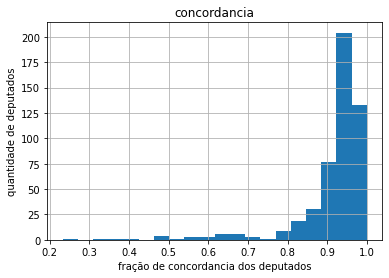

In [43]:
concord=pd.DataFrame({'concordancia':concordancia}) #dataset com o quanto cada deputado concorda com seu partido
concord[concord.concordancia!=0].hist(bins=20)
plt.ylabel('quantidade de deputados')
plt.xlabel('fração de concordancia dos deputados')
plt.title()

In [40]:
df_indexed.loc[concord[concord.concordancia!=0].sort_values('concordancia').head().index]

,nome,siglaUf,siglaPartido,idLegislatura,cod_deputado,2083376-58,2160860-213,2160860-202,2160860-198,2160860-190,...,2292163-88,2292163-85,2292163-81,2292163-77,2292163-72,2292163-66,2293710-37,2297870-6,2297849-7,2297227-10
160541,Arthur Lira,AL,PP,56,160541,NaN,NaN,NaN,NaN,NaN,...,Artigo 17,Artigo 17,Artigo 17,Artigo 17,Artigo 17,Artigo 17,Artigo 17,Artigo 17,Artigo 17,Artigo 17
204366,Rodrigo Coelho,SC,PSB,56,204366,Não,Sim,Não,Não,Não,...,Sim,Sim,Não,Sim,Não,Sim,Sim,NaN,Não,Não
69871,Bacelar,BA,PODE,56,69871,NaN,Não,Sim,Sim,Não,...,Não,Sim,Sim,Sim,Sim,Não,Sim,Não,Não,Sim
74273,Jefferson Campos,SP,PSB,56,74273,NaN,Não,Sim,NaN,Não,...,Sim,Sim,Não,Sim,Sim,Não,Sim,Não,Sim,Sim
204403,Marlon Santos,RS,PDT,56,204403,NaN,Não,Sim,NaN,Não,...,Não,Sim,Sim,Não,Sim,Não,Sim,Não,Sim,Sim


In [42]:
concord[concord.concordancia!=0].sort_values('concordancia').head()

,concordancia
160541,0.232500
204366,0.337243
69871,0.361564
74273,0.411697
204403,0.473046


Aqui vemos que os deputados costumam concordar bem com os partidos. A maior parte concorda entre 90% a 100% com seus partidos. Isso significa que para os deputados que não estão presentes nas votações, podemos substituir, se existir, com a orientação de seu partido.

### Imputando dados faltantes dos partidos

Esse tipo de procedimento é bem simples de se fazer. A maneira mais tranquila, na minha visão, é usando uma tabela como pivot para essa comparação. ela contem os mesmos dados que as orientações dos partidos, mas agora organizado de acordo com cada deputado ao invez de cada partido.

In [53]:
fillna_pivot = pd.merge(df_indexed[['siglaPartido']], orientacoes, how='left', left_on='siglaPartido', right_on='partido')
df_indexed[votacoes_orientacoes] = df_indexed[votacoes_orientacoes].fillna(fillna_pivot[votacoes_orientacoes])

### Limpeza do dataset

Sera que mesmo depois de preencher os dados faltantes com o que dava ainda tem muitos valores faltando? é o que eu decidi investigar com esse histograma aqui:

Text(0, 0.5, 'quantidade')

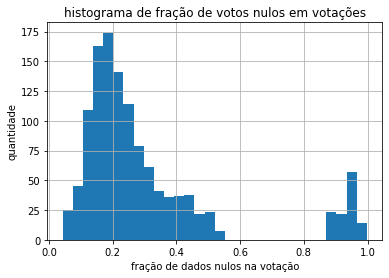

In [26]:
votacoes_df_indexed=df_indexed.columns.drop(['nome','siglaUf', 'siglaPartido', 'idLegislatura', 'cod_deputado'])
df_indexed[votacoes_df_indexed].isna().mean().hist(bins=30)
plt.title('histograma de fração de votos nulos em votações')
plt.xlabel('fração de dados nulos na votação')
plt.ylabel('quantidade')

Vemos que um grande número de votações tem mais de 80% de seus dados em falta, e esse tipo de dado não vale a pena de manter no dataset dado que os dados que ja temos são suficientes para uma clusterização razoavel dos dados. O parametro eu eu usei foi de que, se tiver mais que 40% dos dados em falta essa votação pode ser excluída.

In [294]:
votacoes_df_indexed_04=votacoes_df_indexed[df_indexed[votacoes_df_indexed].isna().mean()>=0.4]
votacoes_df_indexed_clean=votacoes_df_indexed.drop(votacoes_df_indexed_04)
df_indexed_clean=df_indexed.drop(votacoes_df_indexed_04, axis=1)

### Numerização dos dados

O ultimo passo realizado nessa parte do projeto foi transformar o que foi votado por cada deputado em algo numérico. Isso é um procedimento necessario porque a maioria dos métodos de clusterização trabalha com valores numericos e meio geometricos, então não da para tentar processar 'Sim' e 'Não', é preciso transformar em 1 e 0. O modelo de numerização nesse caso foi a de que: se algum deputado votou 'Sim' esse voto vira 1, se algum deputado votou 'Não' esse voto vira 0, e qualquer outra opção ('Obstrução', 'Abstenção', 'Artigo-17'). Aqui eu ja salvei os dados limpos em um único dataset, para ser usado na ultima parte desse projeto.

In [298]:
for col in votacoes_df_indexed_clean:
    majority=df_indexed_clean[col].value_counts().index[0]
    if majority=='Sim':
        majority_num=1
    if majority=='Não':
        majority_num=0
    df_indexed_clean[col]=df_indexed_clean[col].fillna(0.5)
    votes_map={'Sim': 1, 'Não':0, 'Obstrução':0.5, 'Artigo 17':0.5, 'Abstenção':0.5, 0.5:0.5}
    df_indexed_clean[col]=df_indexed_clean[col].apply(lambda x: votes_map[x])
    #df_indexed_clean[col]=df_indexed_clean[col].astype('category')

df_indexed_clean.siglaUf=df_indexed_clean.siglaUf.astype('category')
df_indexed_clean.to_csv(r'data/df.csv')

### Próximos passos


Agora que os dados foram limpos e tratados é hora de fazer a clusterização e outros procedimentos exploratórios sobre o comportamento dos parlamentares. Isso foi realizado nesse artigo aqui: LINK_3. Detalhes sobre como foram extraidos esses dados da camara dos deputados encontram-se nesse artigo aqui: LINK_2.